<h1>Real Options Backtest</h1>

In [1]:
#pip install xlsxwriter

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from pathlib import Path
import xlwings as xw
import json
import matplotlib.ticker as mtick
import statsmodels.formula.api as smf
import statsmodels.api as sm
# Set default matplotlib figure size
plt.rcParams['figure.figsize'] = [10, 5]
from typing import Union, List, Tuple, Dict, Any, Iterable, Optional
import math
from pandas import ExcelWriter
import matplotlib.pyplot as plt

<h2>Data Wrangle</h2>

<h3>Load Data</h3>

In [3]:
accounting_df = pd.read_csv('accounting_hw2_new.csv')
return_df = pd.read_csv('return_hw2.csv')
fama_french_df = pd.read_csv('risk_free_rate.csv')

<h3>Standard Data Clean Accounting</h3>

In [4]:
# filter out securities listed on irrelevant exchanges
accounting_df = accounting_df[(accounting_df['exchg'] >= 11) & (accounting_df['exchg'] <= 19)]
accounting_df = accounting_df[accounting_df['curcd'] == 'USD']
accounting_df = accounting_df[accounting_df['fic'].str.contains('USA')]
accounting_df = accounting_df[~((accounting_df['sic'] >= 6000) & (accounting_df['sic'] <= 6999))] # filter out financial companies
accounting_df = accounting_df[~(accounting_df['sic'] == 2834)] # filter out pharma companies
accounting_df['datadate'] = pd.to_datetime(accounting_df['datadate']) # turn datadate col into datetime
accounting_df['market_cap'] = accounting_df['prcc_f']*accounting_df['csho'] # create new col for mkt cap
accounting_df['intano'] = accounting_df['intano'].fillna(0) # convert NaN values to 0 for calculations below
accounting_df['market_cap'] = accounting_df['market_cap'].fillna(0) # convert NaN values to 0 for calculations below
accounting_df['oancf'] = accounting_df['oancf'].fillna(0) # convert NaN values to 0 for calculations below
accounting_df['capx'] = accounting_df['capx'].fillna(0) # convert NaN values to 0 for calculations below
accounting_df['intan'] = accounting_df['intan'].fillna(0) # convert NaN values to 0 for calculations below
accounting_df['gdwl'] = accounting_df['gdwl'].fillna(0) # convert NaN values to 0 for calculations below
accounting_df['acqintan'] = accounting_df['acqintan'].fillna(0) # convert NaN values to 0 for calculations below
#Shift forward 3 months to avoid lookahead bias
#add 3 months do accountind_df datadate
accounting_df['datadate'] = accounting_df['datadate'] + pd.DateOffset(months=3)
accounting_df = accounting_df[['datadate', 'LPERMNO', 'intano','gp','revt','oancf','capx','sic','ggroup','gind','gsector','gsubind','market_cap','intan', 'gdwl', 'acqintan', 'tic']] # remove rest of un-needed cols
accounting_df['year'] = accounting_df['datadate'].dt.year
accounting_df['year'] = accounting_df['year'].astype(int)
# add 1 to year to get the next year for return trading
accounting_df['year'] = accounting_df['year'] + 1
# create new column for the year
accounting_df = accounting_df[~(accounting_df['market_cap'] < 10)] # filter out small market_cap companies
accounting_df.sort_values (by=['LPERMNO', 'datadate'], ascending=False, inplace=True) # filter instances where there are multiple LPERMNO values for the same year
accounting_df = accounting_df.drop_duplicates(subset=['year', 'LPERMNO'])
accounting_df = accounting_df[~accounting_df['gp'].isna()] #drop all rows where gp is nan
accounting_df = accounting_df[~accounting_df['revt'].isna()] #drop all rows where revt is nan
accounting_df = accounting_df[accounting_df['revt'] > 0] #drop all rows where revt is less than or equal to 0
accounting_df = accounting_df[~accounting_df['gsubind'].isna()] #drop rows where gsubind is nan
accounting_df['gsubind'] = accounting_df['gsubind'].astype(int)

<h3>Standard Data Clean Return</h3>

In [5]:
return_df = return_df[(return_df['exchg'] >= 11) & (return_df['exchg'] <= 19)] # filter out securities listed on irrelevant exchanges
return_df = return_df[return_df['fic'].str.contains('USA')] # filter out securities not listed in the US
return_df = return_df[~((return_df['sic'] >= 6000) & (return_df['sic'] <= 6999))] # filter out financial companies
return_df = return_df[~(return_df['sic'] == 2834)] # filter out pharma companies
return_df['trt1m'] = pd.to_numeric(return_df['trt1m'], errors='coerce') # convert non-numeric values to NaN
return_df = return_df.dropna(subset=['trt1m']) # remove rows with NaN in 'trt1m' column
return_df = return_df[~(return_df['trt1m'] < -100)] # filter out returns below -100
return_df = return_df[return_df['trt1m'] < 1000] # filter out returns above 1000
return_df['datadate'] = pd.to_datetime(return_df['datadate']) # turn datadate col into datetime
return_df = return_df[['datadate', 'LPERMNO', 'trt1m']] # filter out un-needed cols
return_df['month'] = return_df['datadate'].dt.month # create new col for month
return_df['year'] = return_df['datadate'].dt.year # create new col for year

<h3>Standard Data Clean Fama French</h3>

In [6]:
fama_french_df.rename(columns={'Unnamed: 0': 'datadate'}, inplace=True) #rename Unamed: 0 to datadate
fama_french_df = fama_french_df[:1169] #keep only monthly return section
fama_french_df['datadate'] = pd.to_datetime(fama_french_df['datadate'], format='%Y%m')
fama_french_df['year_month'] = fama_french_df['datadate'].dt.to_period('M')
fama_french_df.set_index('year_month', inplace=True)
fama_french_df.drop(columns='datadate', inplace=True)
#Only keep data until 2022-12
fama_french_df = fama_french_df[:'2022-12']
rf = fama_french_df['RF']

<h3>Create Sorting Variable</h3>

In [7]:
#Filter for the years 1980-07-01 to 2012-12-31
accounting_df = accounting_df[(accounting_df['datadate'] >= '1970-07-01') & (accounting_df['datadate'] <= '2022-12-31')]
return_df = return_df[(return_df['datadate'] >= '1980-07-01') & (return_df['datadate'] <= '2022-12-31')]
#drop all rows where gsector is 60
#This the real estate sector and there are some years with only one company in it. Additionally, it does not make sense in this strategy
accounting_df = accounting_df[accounting_df['gsector'] != 60]
#Calculate FCFF as Operating Cash Flow minus capex
accounting_df['FCFF'] = accounting_df['oancf'] - accounting_df['capx']

In [14]:
#Calculate INTAN2 as INTAN - GDWL to exclude goodwill from intangible assets
accounting_df['intan2'] = accounting_df['intan'] - accounting_df['gdwl']

In [15]:
sum_revt_sector = accounting_df.groupby(['year', 'gsector'])['revt'].sum().reset_index()
accounting_df = pd.merge(accounting_df, sum_revt_sector, left_on=['year', 'gsector'], right_on=['year', 'gsector'], suffixes=('', '_sector'))
accounting_df['market_share'] = accounting_df['revt'] / accounting_df['revt_sector']

In [16]:
accounting_df['gross_margin'] = accounting_df['gp'] / accounting_df['revt']
average_sector = accounting_df.groupby(['year', 'gsector'])['gross_margin','intan2','FCFF','market_share'].mean().reset_index()
std_sector = accounting_df.groupby(['year', 'gsector'])['gross_margin','intan2','FCFF','market_share'].std().reset_index()
sector_df = pd.merge(average_sector, std_sector, on=['year', 'gsector'], suffixes=('_avg', '_std'))
sector_df.rename(columns={'gross_margin_avg': 'gm_sector_avg', 'intan2_avg': 'intan2_sector_avg', 'market_share_avg': 'mktshare_sector_avg', 'gross_margin_std': 'gm_sector_std', 'intan2_std': 'intan2_sector_std','market_share_std': 'mktshare_sector_std', 'FCFF_avg': 'FCFF_sector_avg', 'FCFF_std': 'FCFF_sector_std'}, inplace=True)
#Merge sector_df with accounting_df
accounting_df = pd.merge(accounting_df, sector_df, on=['year', 'gsector'])

/var/folders/24/v3l1p7rd36lg9y_cvv9m0f1c0000gn/T/ipykernel_88936/2798017169.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_sector = accounting_df.groupby(['year', 'gsector'])['gross_margin','intan2','FCFF','market_share'].mean().reset_index()
/var/folders/24/v3l1p7rd36lg9y_cvv9m0f1c0000gn/T/ipykernel_88936/2798017169.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  std_sector = accounting_df.groupby(['year', 'gsector'])['gross_margin','intan2','FCFF','market_share'].std().reset_index()


In [17]:
#standardize variables
accounting_df['gm_z'] = (accounting_df['gross_margin'] - accounting_df['gm_sector_avg']) / accounting_df['gm_sector_std']
accounting_df['intano_z'] = (accounting_df['intan2'] - accounting_df['intan2_sector_avg']) / accounting_df['intan2_sector_std']
accounting_df['mktshare_z'] = (accounting_df['market_share'] - accounting_df['mktshare_sector_avg']) / accounting_df['mktshare_sector_std'] #Did not end up using this variable as it made results worse
#calculate t-variable as average between both standardised variables
accounting_df['t_variable'] = (accounting_df['gm_z'] + accounting_df['intano_z']) / 2

<h3>Scaling</h3>

In [ ]:
#This is a necessary shift to avoid negative and zero values in the z-scores for the standardized variables
#set t_variables equal to -4 where t_variable is less than -4
accounting_df['t_variable'] = np.where(accounting_df['t_variable'] < -4, -4, accounting_df['t_variable'])
#Increment t_variable by 5 to allow t_variable to be scaled by the variance
accounting_df['t_variable'] = accounting_df['t_variable'] + 5

In [19]:
accounting_df['t_variable'].describe()

count    149710.000000
mean          5.010595
std           0.597529
min           1.000000
25%           4.902905
50%           4.967204
75%           5.038616
max          22.062403
Name: t_variable, dtype: float64

In [20]:
# Ensure 'datadate' is a datetime type
accounting_df['datadate'] = pd.to_datetime(accounting_df['datadate'])

# Set 'datadate' as the index
accounting_df.set_index('datadate', inplace=True)

accounting_df.sort_values(by=['LPERMNO', 'datadate'], inplace=True)
def rolling_std(group):
    return group.rolling(window='1825D', min_periods=1).std()
accounting_df['FCFF_5yr_std'] = accounting_df.groupby('LPERMNO')['FCFF'].apply(rolling_std)
accounting_df['FCFF_5yr_std'] = accounting_df['FCFF_5yr_std'].fillna(0)


/var/folders/24/v3l1p7rd36lg9y_cvv9m0f1c0000gn/T/ipykernel_88936/703469796.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  accounting_df['FCFF_5yr_std'] = accounting_df.groupby('LPERMNO')['FCFF'].apply(rolling_std)


In [21]:
accounting_df.sort_values(by=['LPERMNO', 'datadate'], inplace=True)
def rolling_mean(group):
    return group.rolling(window='1825D', min_periods=1).mean()
accounting_df['FCFF_5yr_mean'] = accounting_df.groupby('LPERMNO')['FCFF'].apply(rolling_mean)
accounting_df['FCFF_5yr_mean'] = accounting_df['FCFF_5yr_std'].fillna(0)

/var/folders/24/v3l1p7rd36lg9y_cvv9m0f1c0000gn/T/ipykernel_88936/2556366535.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  accounting_df['FCFF_5yr_mean'] = accounting_df.groupby('LPERMNO')['FCFF'].apply(rolling_mean)


In [22]:
accounting_df

,LPERMNO,intano,gp,revt,oancf,capx,sic,ggroup,gind,gsector,...,gm_sector_std,intan2_sector_std,FCFF_sector_std,mktshare_sector_std,gm_z,intano_z,mktshare_z,t_variable,FCFF_5yr_std,FCFF_5yr_mean
datadate,,,,,,,,,,,,,,,,,,,,,
1990-09-30,10001,0.000,3.320,23.227,1.894,1.173,4924,5510.0,551020.0,55.0,...,0.122802,89.211319,197.808966,0.008983,-1.027477,-0.108502,-0.653011,4.432010,0.000000,0.000000
1991-09-30,10001,0.000,3.168,23.850,1.954,1.202,4924,5510.0,551020.0,55.0,...,0.328023,88.563318,177.075282,0.009601,-0.331948,-0.115959,-0.630402,4.776047,0.021920,0.021920
1992-09-30,10001,0.000,2.907,22.950,2.364,1.266,4924,5510.0,551020.0,55.0,...,0.111816,85.638471,192.194838,0.008664,-1.288452,-0.119868,-0.694710,4.295840,0.209287,0.209287
1993-09-30,10001,0.000,4.027,27.629,1.464,2.468,4924,5510.0,551020.0,55.0,...,20.949377,82.335992,176.606221,0.008412,0.071568,-0.120925,-0.704247,4.975322,0.946061,0.946061
1994-09-30,10001,0.000,4.100,27.680,2.851,2.626,4924,5510.0,551020.0,55.0,...,0.169592,78.938994,220.005403,0.008212,-0.705141,-0.125677,-0.713546,4.584591,0.822699,0.822699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-31,93436,361.502,3858.490,11758.751,-60.654,4081.354,3711,2510.0,251020.0,25.0,...,0.189774,1348.675084,1228.800240,0.007423,-0.175027,-0.012236,0.433210,4.906368,1539.679229,1539.679229
2019-03-31,93436,282.492,5929.807,21461.268,2097.802,2319.516,3711,2510.0,251020.0,25.0,...,5.611909,1131.319861,1325.674377,0.007942,0.042329,-0.079669,0.911420,4.981330,1479.462224,1479.462224
2020-03-31,93436,339.000,6176.000,24578.000,2405.000,1432.000,3711,2510.0,251020.0,25.0,...,0.725569,888.671369,1491.139962,0.008620,-0.094985,0.020920,0.974649,4.962967,1945.448793,1945.448793


In [23]:
accounting_df['FCFF_std/avg'] = accounting_df['FCFF_5yr_std'] / accounting_df['FCFF_5yr_mean']
accounting_df.fillna(0, inplace=True)
accounting_df['sv'] = accounting_df['t_variable'] * accounting_df['FCFF_std/avg']
accounting_df.reset_index(drop=True, inplace=True)

In [24]:
def assign_quintiles(x):
    if len(x) < 5:
        return pd.Series([None] * len(x), index=x.index)
    else:
        try:
            return pd.qcut(x, 5, labels=False, duplicates='drop') + 1
        except ValueError:
            return pd.Series([None] * len(x), index=x.index)

accounting_df['quintile'] = accounting_df.groupby('year')['sv'].transform(assign_quintiles)


In [25]:
accounting_df

,LPERMNO,intano,gp,revt,oancf,capx,sic,ggroup,gind,gsector,...,mktshare_sector_std,gm_z,intano_z,mktshare_z,t_variable,FCFF_5yr_std,FCFF_5yr_mean,FCFF_std/avg,sv,quintile
0,10001,0.000,3.320,23.227,1.894,1.173,4924,5510.0,551020.0,55.0,...,0.008983,-1.027477,-0.108502,-0.653011,4.432010,0.000000,0.000000,0.0,0.000000,1.0
1,10001,0.000,3.168,23.850,1.954,1.202,4924,5510.0,551020.0,55.0,...,0.009601,-0.331948,-0.115959,-0.630402,4.776047,0.021920,0.021920,1.0,4.776047,2.0
2,10001,0.000,2.907,22.950,2.364,1.266,4924,5510.0,551020.0,55.0,...,0.008664,-1.288452,-0.119868,-0.694710,4.295840,0.209287,0.209287,1.0,4.295840,1.0
3,10001,0.000,4.027,27.629,1.464,2.468,4924,5510.0,551020.0,55.0,...,0.008412,0.071568,-0.120925,-0.704247,4.975322,0.946061,0.946061,1.0,4.975322,3.0
4,10001,0.000,4.100,27.680,2.851,2.626,4924,5510.0,551020.0,55.0,...,0.008212,-0.705141,-0.125677,-0.713546,4.584591,0.822699,0.822699,1.0,4.584591,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149707,93436,361.502,3858.490,11758.751,-60.654,4081.354,3711,2510.0,251020.0,25.0,...,0.007423,-0.175027,-0.012236,0.433210,4.906368,1539.679229,1539.679229,1.0,4.906368,2.0
149708,93436,282.492,5929.807,21461.268,2097.802,2319.516,3711,2510.0,251020.0,25.0,...,0.007942,0.042329,-0.079669,0.911420,4.981330,1479.462224,1479.462224,1.0,4.981330,4.0
149709,93436,339.000,6176.000,24578.000,2405.000,1432.000,3711,2510.0,251020.0,25.0,...,0.008620,-0.094985,0.020920,0.974649,4.962967,1945.448793,1945.448793,1.0,4.962967,3.0
149710,93436,313.000,9185.000,31536.000,5943.000,3232.000,3711,2510.0,251020.0,25.0,...,0.010277,0.053236,-0.005468,1.123822,5.023884,2595.262266,2595.262266,1.0,5.023884,4.0


<h1> EDA </h1>

<h2> Plot average Number of Companies in each Sector per Year </h2>

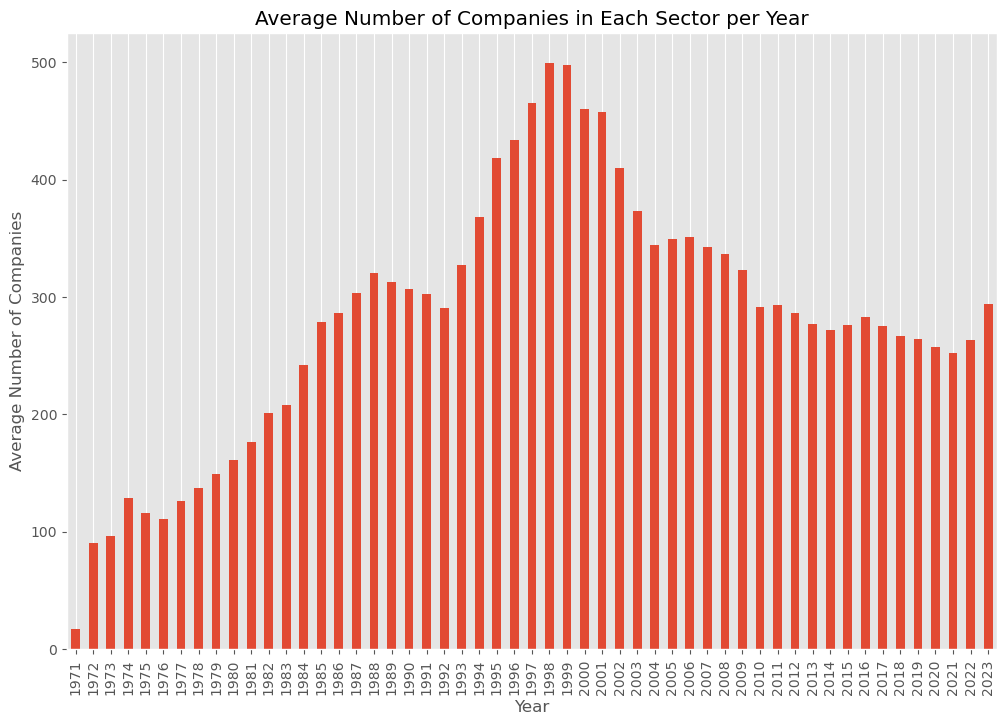

In [26]:
# Plot the data as a stacked bar plot
gsector_counts = accounting_df.groupby(['year', 'gsector']).size().groupby('year').mean()
gsector_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.xlabel('Year')
plt.ylabel('Average Number of Companies')
plt.title('Average Number of Companies in Each Sector per Year')
plt.grid(axis='y')
plt.show()

In [27]:
#show number of rows in each quintile for each year
accounting_df.groupby(['year', 'quintile']).size()

year  quintile
1972  1.0         905
1973  1.0         194
      2.0         193
      3.0         194
      4.0         193
                 ... 
2023  1.0         588
      2.0         587
      3.0         588
      4.0         587
      5.0         588
Length: 255, dtype: int64

<h2> Plot number of Companies in each Quintile per Year </h2>

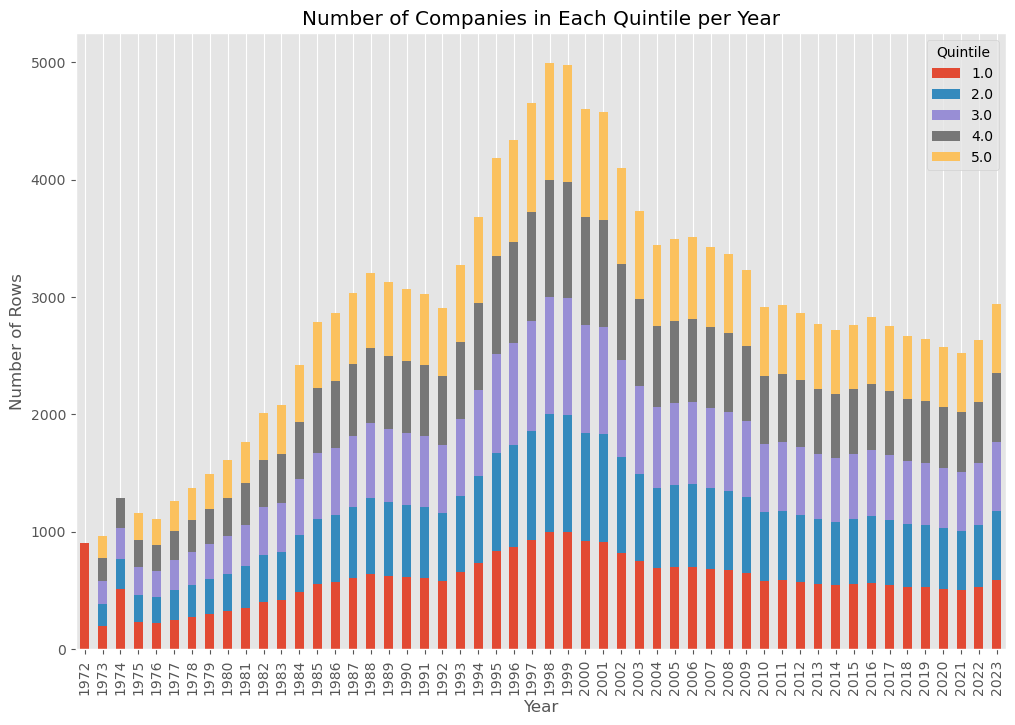

In [28]:
# Plot the data as a stacked bar plot
quintile_counts = accounting_df.groupby(['year', 'quintile']).size().unstack()
quintile_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.xlabel('Year')
plt.ylabel('Number of Rows')
plt.title('Number of Companies in Each Quintile per Year')
plt.legend(title='Quintile')
plt.grid(axis='y')
plt.show()

In [29]:
merged_df = pd.merge(return_df, accounting_df[['year', 'LPERMNO', 'gsector','market_cap', 't_variable', 'quintile']], on=['year', 'LPERMNO'], how='inner')
merged_df.sort_values(by=['datadate','LPERMNO'], ascending=True, inplace=True)
#set datadate and LPERMNO as index
merged_df.set_index(['datadate', 'LPERMNO'], inplace=True)

In [30]:
merged_df

trt1m  month  year  gsector     market_cap  t_variable  \
datadate   LPERMNO                                                             
1980-07-31 10057    11.3402      7  1980     45.0     101.205000    4.398417   
           10137    -5.2239      7  1980     55.0     537.524500    6.057042   
           10145     7.0496      7  1980     20.0     805.633282    5.527128   
           10153    12.1359      7  1980     10.0     349.246793    6.652353   
           10154    35.5932      7  1980     20.0      10.029370    4.822008   
...                     ...    ...   ...      ...            ...         ...   
2022-12-31 93397    -4.3224     12  2022     30.0     243.504810    4.048318   
           93423    -3.4869     12  2022     25.0    2901.091600    4.992686   
           93426    -4.7326     12  2022     45.0     427.341000    4.916832   
           93434    34.2342     12  2022     30.0     133.762720    4.283044   
           93436   -36.7334     12  2022     25.0  677443.200000    5.023884   

                    quintile  
datadate   LPERMNO            
1980-07-31 10057         1.0  
           10137         5.0  
           10145         5.0  
           10153         5.0  
           10154         1.0  
...                      ...  
2022-12-31 93397         1.0  
           93423         4.0  
           93426         2.0  
           93434         1.0  
           93436         4.0  

[1505282 rows x 7 columns]

<h1>Calculate Returns for given time periods:</h1>

<h3>Equal-weighted Returns</h3>

In [31]:
#Define timeframes
Full_sample_start = '1981-07-01'
Full_sample_end = '2012-12-31'

Pre_2000_start = '1981-07-31'
Pre_2000_end = '1999-12-31'

Post_2000_start = '2000-01-01'
Post_2000_end = '2012-12-31'

Extended_period_start = '2013-01-01'
Extended_period_end = '2022-12-31'

# Define time frames
time_frames = {
    'Full_sample': (Full_sample_start, Full_sample_end),
    'Pre_2000': (Pre_2000_start, Pre_2000_end),
    'Post_2000': (Post_2000_start, Post_2000_end),
    'Extended_period': (Extended_period_start, Extended_period_end)
}

#Function to calculate the average return for each quintile
def calculate_average_EW_returns(df, time_frames):
    results = {}
    for time_frame, dates in time_frames.items():
        start_date, end_date = dates
        start_year, start_month, _ = map(int, start_date.split('-'))
        end_year, end_month, _ = map(int, end_date.split('-'))

        df_filtered = df[((df['year'] > start_year) | ((df['year'] == start_year) & (df['month'] >= start_month))) &
                         ((df['year'] < end_year) | ((df['year'] == end_year) & (df['month'] <= end_month)))]

        averages = df_filtered[['Q1_EW_returns', 'Q2_EW_returns', 'Q3_EW_returns', 'Q4_EW_returns', 'Q5_EW_returns']].mean()
        results[time_frame] = averages
    return results

In [32]:
merged_df.sort_values(by=['LPERMNO', 'year'], inplace=True)
ew_returns = merged_df.groupby(['year', 'month', 'quintile'])['trt1m'].mean()
ew_returns = ew_returns.unstack(level='quintile')
new_column_names = {1.0: 'Q1_EW_returns',2.0: 'Q2_EW_returns',3.0: 'Q3_EW_returns',4.0: 'Q4_EW_returns',5.0: 'Q5_EW_returns'}
ew_returns.rename(columns=new_column_names, inplace=True)
ew_returns = ew_returns.reset_index()

In [33]:
ew_returns

quintile,year,month,Q1_EW_returns,Q2_EW_returns,Q3_EW_returns,Q4_EW_returns,Q5_EW_returns
0,1980,7,12.712358,12.055199,9.660807,11.397031,11.795089
1,1980,8,9.068475,6.413842,4.491091,4.754689,5.142374
2,1980,9,4.479591,2.874620,2.680692,2.775994,4.071201
3,1980,10,4.845703,3.314676,2.235590,1.215719,2.545315
4,1980,11,6.795301,5.819563,5.913098,5.677819,8.179765
...,...,...,...,...,...,...,...
505,2022,8,2.643999,0.224647,-1.255615,-1.056489,-1.722648
506,2022,9,-14.306203,-13.407875,-11.069276,-11.494054,-10.764639
507,2022,10,6.281475,8.641200,10.386271,5.505486,10.884281
508,2022,11,-1.030378,3.512061,4.127944,0.691894,5.286935


<h2>Calculate the Returns for each Quintile and Timeframe for equal weighted portfolio</h2>

In [34]:
average_ew_returns = calculate_average_EW_returns(ew_returns, time_frames)

# Print the average returns for each time frame
for time_frame, averages in average_ew_returns.items():
    print(f"{time_frame}:")
    print(averages)

Full_sample:
quintile
Q1_EW_returns    0.823173
Q2_EW_returns    1.152880
Q3_EW_returns    1.202737
Q4_EW_returns    1.143997
Q5_EW_returns    1.195773
dtype: float64
Pre_2000:
quintile
Q1_EW_returns    0.853018
Q2_EW_returns    1.125334
Q3_EW_returns    1.114134
Q4_EW_returns    1.209711
Q5_EW_returns    1.244689
dtype: float64
Post_2000:
quintile
Q1_EW_returns    0.780700
Q2_EW_returns    1.192080
Q3_EW_returns    1.328825
Q4_EW_returns    1.050482
Q5_EW_returns    1.126163
dtype: float64
Extended_period:
quintile
Q1_EW_returns    0.763493
Q2_EW_returns    0.999252
Q3_EW_returns    1.173881
Q4_EW_returns    0.944936
Q5_EW_returns    1.130242
dtype: float64


<h2> Save the returns to excel file for ease of Presentation Creation </h2>

In [35]:
def calculate_average_returns(df, time_frames):
    results = []
    for time_frame, dates in time_frames.items():
        start_date, end_date = dates
        start_year, start_month, _ = map(int, start_date.split('-'))
        end_year, end_month, _ = map(int, end_date.split('-'))

        df_filtered = df[((df['year'] > start_year) | ((df['year'] == start_year) & (df['month'] >= start_month))) &
                         ((df['year'] < end_year) | ((df['year'] == end_year) & (df['month'] <= end_month)))]

        averages = df_filtered[['Q1_EW_returns', 'Q2_EW_returns', 'Q3_EW_returns', 'Q4_EW_returns', 'Q5_EW_returns']].mean()
        averages.name = time_frame
        results.append(averages)
    return pd.concat(results, axis=1)

# Example usage
average_ew_returns = calculate_average_returns(ew_returns, time_frames)
#Transpose the output
average_ew_returns = average_ew_returns.T
average_ew_returns.to_excel('average_ew_returns.xlsx')

# If you want to print the average returns for each time frame
print(average_ew_returns)

quintile         Q1_EW_returns  Q2_EW_returns  Q3_EW_returns  Q4_EW_returns  \
Full_sample           0.823173       1.152880       1.202737       1.143997   
Pre_2000              0.853018       1.125334       1.114134       1.209711   
Post_2000             0.780700       1.192080       1.328825       1.050482   
Extended_period       0.763493       0.999252       1.173881       0.944936   

quintile         Q5_EW_returns  
Full_sample           1.195773  
Pre_2000              1.244689  
Post_2000             1.126163  
Extended_period       1.130242  


<h3>Value-weighted Returns</h3>

In [36]:
#Function to calculate the average return for each quintile
def calculate_average_VW_returns(df, time_frames):
    results = {}
    for time_frame, dates in time_frames.items():
        start_date, end_date = dates
        start_year, start_month, _ = map(int, start_date.split('-'))
        end_year, end_month, _ = map(int, end_date.split('-'))

        df_filtered = df[((df['year'] > start_year) | ((df['year'] == start_year) & (df['month'] >= start_month))) &
                         ((df['year'] < end_year) | ((df['year'] == end_year) & (df['month'] <= end_month)))]

        averages = df_filtered[['Q1_VW_returns', 'Q2_VW_returns', 'Q3_VW_returns', 'Q4_VW_returns', 'Q5_VW_returns']].mean()
        results[time_frame] = averages
    return results

In [37]:
quintile_mktcap = merged_df.groupby(['year','month','quintile'])['market_cap'].sum()
quintile_mktcap = quintile_mktcap.unstack(level='quintile')
quintile_mktcap.reset_index(inplace=True)
new_column_names = {1.0: 'Q1_mktcap',2.0: 'Q2_mktcap',3.0: 'Q3_mktcap',4.0: 'Q4_mktcap',5.0: 'Q5_mktcap'}
quintile_mktcap.rename(columns=new_column_names, inplace=True)

In [38]:
quintile_mktcap

quintile,year,month,Q1_mktcap,Q2_mktcap,Q3_mktcap,Q4_mktcap,Q5_mktcap
0,1980,7,4.206243e+04,1.245051e+05,8.108257e+04,9.030875e+04,2.590264e+05
1,1980,8,4.206243e+04,1.245051e+05,8.108257e+04,9.030875e+04,2.590264e+05
2,1980,9,4.198232e+04,1.245051e+05,8.108257e+04,9.030875e+04,2.590264e+05
3,1980,10,4.198232e+04,1.245051e+05,8.108257e+04,9.030875e+04,2.590264e+05
4,1980,11,4.159317e+04,1.245051e+05,8.108257e+04,9.030875e+04,2.590264e+05
...,...,...,...,...,...,...,...
505,2022,8,2.175772e+06,4.529445e+06,2.979967e+06,6.594274e+06,1.978068e+07
506,2022,9,2.169804e+06,4.527460e+06,2.973998e+06,6.591513e+06,1.978007e+07
507,2022,10,2.169759e+06,4.527460e+06,2.948987e+06,6.590265e+06,1.977152e+07
508,2022,11,2.166905e+06,4.527377e+06,2.931854e+06,6.583107e+06,1.971381e+07


In [39]:
merged_df.reset_index(inplace=True)
# Merge the DataFrames on 'year' and 'month' columns
merged_df = pd.merge(merged_df, quintile_mktcap, on=['year', 'month'])

# Calculate the portfolio weight for each stock in its quintile
for quintile in range(1, 6):
    total_mktcap_column = f'Q{quintile}_mktcap'
    merged_df.loc[merged_df['quintile'] == quintile, 'portfolio_weight'] = merged_df['market_cap'] / merged_df[total_mktcap_column]

#Calculate the weighted return for each stock
merged_df['weighted_return'] = merged_df['trt1m'] * merged_df['portfolio_weight']

In [40]:
merged_df.sort_values(by=['LPERMNO', 'year'], inplace=True)
vw_returns = merged_df.groupby(['year', 'month', 'quintile'])['weighted_return'].sum()
vw_returns = vw_returns.unstack(level='quintile')
new_column_names = {1.0: 'Q1_VW_returns',2.0: 'Q2_VW_returns',3.0: 'Q3_VW_returns',4.0: 'Q4_VW_returns',5.0: 'Q5_VW_returns'}
vw_returns.rename(columns=new_column_names, inplace=True)
vw_returns = vw_returns.reset_index()

In [41]:
vw_returns

quintile,year,month,Q1_VW_returns,Q2_VW_returns,Q3_VW_returns,Q4_VW_returns,Q5_VW_returns
0,1980,7,7.060851,6.263931,7.238160,8.666449,8.763897
1,1980,8,3.473529,2.447563,0.772899,0.950596,1.894175
2,1980,9,2.859044,4.613927,0.639519,0.561300,0.665881
3,1980,10,4.667242,5.280519,0.868924,-1.187312,-0.306156
4,1980,11,17.768396,12.307009,5.512069,3.929599,5.344642
...,...,...,...,...,...,...,...
505,2022,8,-0.249053,-2.271395,-3.064277,-5.455535,-3.894515
506,2022,9,-12.365697,-9.871918,-10.527485,-10.017878,-10.355194
507,2022,10,5.720836,10.734915,9.528736,2.862563,5.681981
508,2022,11,4.473701,2.208037,2.770877,5.847106,7.203110


<h2> Calculate Average Returns for each quintile and timeframe for Value-Weighted Portfolios </h2>

In [42]:
average_vw_returns = calculate_average_VW_returns(vw_returns, time_frames)

# Print the average returns for each time frame
for time_frame, averages in average_vw_returns.items():
    print(f"{time_frame}:")
    print(averages)

Full_sample:
quintile
Q1_VW_returns    1.013068
Q2_VW_returns    1.086421
Q3_VW_returns    0.915226
Q4_VW_returns    1.000140
Q5_VW_returns    1.008124
dtype: float64
Pre_2000:
quintile
Q1_VW_returns    1.354194
Q2_VW_returns    1.399476
Q3_VW_returns    1.176897
Q4_VW_returns    1.354468
Q5_VW_returns    1.326428
dtype: float64
Post_2000:
quintile
Q1_VW_returns    0.527618
Q2_VW_returns    0.640919
Q3_VW_returns    0.542848
Q4_VW_returns    0.495905
Q5_VW_returns    0.555151
dtype: float64
Extended_period:
quintile
Q1_VW_returns    0.813179
Q2_VW_returns    0.854881
Q3_VW_returns    1.236307
Q4_VW_returns    1.046018
Q5_VW_returns    1.075059
dtype: float64


<h2> Save the returns to excel file for ease of Presentation Creation </h2>

In [43]:
def calculate_average_returns(df, time_frames):
    results = []
    for time_frame, dates in time_frames.items():
        start_date, end_date = dates
        start_year, start_month, _ = map(int, start_date.split('-'))
        end_year, end_month, _ = map(int, end_date.split('-'))

        df_filtered = df[((df['year'] > start_year) | ((df['year'] == start_year) & (df['month'] >= start_month))) &
                         ((df['year'] < end_year) | ((df['year'] == end_year) & (df['month'] <= end_month)))]

        averages = df_filtered[['Q1_VW_returns', 'Q2_VW_returns', 'Q3_VW_returns', 'Q4_VW_returns', 'Q5_VW_returns']].mean()
        averages.name = time_frame
        results.append(averages)
    return pd.concat(results, axis=1)

# Example usage
average_vw_returns = calculate_average_returns(vw_returns, time_frames)
#Transpose the output
average_vw_returns = average_vw_returns.T
average_vw_returns.to_excel('average_vw_returns.xlsx')

# If you want to print the average returns for each time frame
print(average_vw_returns)

quintile         Q1_VW_returns  Q2_VW_returns  Q3_VW_returns  Q4_VW_returns  \
Full_sample           1.013068       1.086421       0.915226       1.000140   
Pre_2000              1.354194       1.399476       1.176897       1.354468   
Post_2000             0.527618       0.640919       0.542848       0.495905   
Extended_period       0.813179       0.854881       1.236307       1.046018   

quintile         Q5_VW_returns  
Full_sample           1.008124  
Pre_2000              1.326428  
Post_2000             0.555151  
Extended_period       1.075059  


In [44]:
vw_returns.isna().sum()

quintile
year             0
month            0
Q1_VW_returns    0
Q2_VW_returns    0
Q3_VW_returns    0
Q4_VW_returns    0
Q5_VW_returns    0
dtype: int64

In [45]:
ew_returns

quintile,year,month,Q1_EW_returns,Q2_EW_returns,Q3_EW_returns,Q4_EW_returns,Q5_EW_returns
0,1980,7,12.712358,12.055199,9.660807,11.397031,11.795089
1,1980,8,9.068475,6.413842,4.491091,4.754689,5.142374
2,1980,9,4.479591,2.874620,2.680692,2.775994,4.071201
3,1980,10,4.845703,3.314676,2.235590,1.215719,2.545315
4,1980,11,6.795301,5.819563,5.913098,5.677819,8.179765
...,...,...,...,...,...,...,...
505,2022,8,2.643999,0.224647,-1.255615,-1.056489,-1.722648
506,2022,9,-14.306203,-13.407875,-11.069276,-11.494054,-10.764639
507,2022,10,6.281475,8.641200,10.386271,5.505486,10.884281
508,2022,11,-1.030378,3.512061,4.127944,0.691894,5.286935


In [46]:
ew_returns['HILO_LS_EW_premium'] = ew_returns['Q5_EW_returns'] - ew_returns['Q1_EW_returns']
vw_returns['HILO_LS_VW_premium'] = vw_returns['Q5_VW_returns'] - vw_returns['Q1_VW_returns']
#Create year_month column
ew_returns['year_month'] = ew_returns['year'].astype(str) + '-' + ew_returns['month'].apply(lambda x: f'{x:02}')
vw_returns['year_month'] = vw_returns['year'].astype(str) + '-' + vw_returns['month'].apply(lambda x: f'{x:02}')

In [47]:
fama_french_df.reset_index(inplace=True)
Regression_df = fama_french_df[['year_month', 'Mkt-RF', 'SMB', 'HML', 'RF']]
Regression_df['year_month'] = Regression_df['year_month'].astype(str)
#Merge the HILO premias into the regression dataframe
Regression_df = pd.merge(Regression_df, ew_returns[['year_month', 'HILO_LS_EW_premium']], on='year_month')
Regression_df = pd.merge(Regression_df, vw_returns[['year_month', 'HILO_LS_VW_premium']], on='year_month')

In [48]:
Regression_df

,year_month,Mkt-RF,SMB,HML,RF,HILO_LS_EW_premium,HILO_LS_VW_premium
0,1980-07,6.49,4.14,-6.41,0.53,-0.917269,1.703046
1,1980-08,1.80,3.92,-2.60,0.64,-3.926100,-1.579354
2,1980-09,2.19,0.98,-4.59,0.75,-0.408391,-2.193163
3,1980-10,1.06,2.47,-2.76,0.95,-2.300389,-4.973399
4,1980-11,9.59,-3.36,-8.33,0.96,1.384464,-12.423754
...,...,...,...,...,...,...,...
505,2022-08,-3.77,1.40,0.29,0.19,-4.366646,-3.645462
506,2022-09,-9.35,-0.81,0.05,0.19,3.541564,2.010503
507,2022-10,7.83,0.06,8.01,0.23,4.602806,-0.038854
508,2022-11,4.60,-3.52,1.38,0.29,6.317312,2.729409


<h1> Run Regression for each timeframe and portfolio </h1>

<h2>CAPM Regression</h2>

In [49]:
#Define timeframes
Full_sample_start = '1981-07-01'
Full_sample_end = '2012-12-31'

Pre_2000_start = '1981-07-31'
Pre_2000_end = '1999-12-31'

Post_2000_start = '2000-01-01'
Post_2000_end = '2012-12-31'

Extended_period_start = '2013-01-01'
Extended_period_end = '2022-12-31'

In [50]:
def run_CAPM_regressions(df, dependent_var, time_frames):
    results = {}
    for time_frame, dates in time_frames.items():
        start_date, end_date = dates
        df_filtered = df[(df['year_month'] >= start_date) & (df['year_month'] <= end_date)]
        
        X = df_filtered[['Mkt-RF']]
        X = sm.add_constant(X)
        y = df_filtered[dependent_var]
        
        model = sm.OLS(y, X).fit()
        results[time_frame] = model.summary()
    return results

# Define time frames
time_frames = {
    'Full_sample': (Full_sample_start, Full_sample_end),
    'Pre_2000': (Pre_2000_start, Pre_2000_end),
    'Post_2000': (Post_2000_start, Post_2000_end),
    'Extended_period': (Extended_period_start, Extended_period_end)
}

#Store the results for each time frame
results_EW_CAPM = run_CAPM_regressions(Regression_df, 'HILO_LS_EW_premium', time_frames)
results_VW_CAPM = run_CAPM_regressions(Regression_df, 'HILO_LS_VW_premium', time_frames)


<h3>Equal Weighted Portfolio </h3>

In [51]:
# To print the results for each time frame
for time_frame, summary in results_EW_CAPM.items():
    print(f"{time_frame} (HILO_LS_EW_premium):")
    print(summary)

Full_sample (HILO_LS_EW_premium):
                            OLS Regression Results                            
Dep. Variable:     HILO_LS_EW_premium   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     22.06
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           3.72e-06
Time:                        16:52:41   Log-Likelihood:                -806.94
No. Observations:                 377   AIC:                             1618.
Df Residuals:                     375   BIC:                             1626.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4

<h3>Value-Weighted Portfolio </h3>

In [52]:
for time_frame, summary in results_VW_CAPM.items():
    print(f"{time_frame} (HILO_LS_VW_premium):")
    print(summary)

Full_sample (HILO_LS_VW_premium):
                            OLS Regression Results                            
Dep. Variable:     HILO_LS_VW_premium   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.685
Date:                Tue, 19 Mar 2024   Prob (F-statistic):              0.102
Time:                        16:52:41   Log-Likelihood:                -845.45
No. Observations:                 377   AIC:                             1695.
Df Residuals:                     375   BIC:                             1703.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0

<h2> Fama-French 3 Factor Model Regression </h2>

In [53]:
#Function for Fama-French Regression
def run_FF3_regressions(df, dependent_var, time_frames):
    results = {}
    for time_frame, dates in time_frames.items():
        start_date, end_date = dates
        df_filtered = df[(df['year_month'] >= start_date) & (df['year_month'] <= end_date)]
        
        X = df_filtered[['Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)
        y = df_filtered[dependent_var]
        
        model = sm.OLS(y, X).fit()
        results[time_frame] = model.summary()
    return results

#Store the results for each time frame
results_EW_FF3 = run_FF3_regressions(Regression_df, 'HILO_LS_EW_premium', time_frames)
results_VW_FF3 = run_FF3_regressions(Regression_df, 'HILO_LS_VW_premium', time_frames)

<h3> Equal-Weighted Portfolio </h3>

In [54]:
# To print the results for each time frame
for time_frame, summary in results_EW_FF3.items():
    print(f"{time_frame} (HILO_LS_EW_premium):")
    print(summary)

Full_sample (HILO_LS_EW_premium):
                            OLS Regression Results                            
Dep. Variable:     HILO_LS_EW_premium   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     41.81
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           2.59e-23
Time:                        16:52:41   Log-Likelihood:                -763.07
No. Observations:                 377   AIC:                             1534.
Df Residuals:                     373   BIC:                             1550.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4

<h3> Value-Weighted Portfolios </h3>

In [55]:
# To print the results for each time frame
for time_frame, summary in results_VW_FF3.items():
    print(f"{time_frame} (HILO_LS_VW_premium):")
    print(summary)

Full_sample (HILO_LS_VW_premium):
                            OLS Regression Results                            
Dep. Variable:     HILO_LS_VW_premium   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     6.989
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           0.000139
Time:                        16:52:41   Log-Likelihood:                -836.48
No. Observations:                 377   AIC:                             1681.
Df Residuals:                     373   BIC:                             1697.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0

<h2>Save all the Regression Outputs to an Excel File for Ease of Presentation Creation </h2>

In [56]:
def save_regression_summaries_to_excel(results_dict, filename):
    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        for result_name, results in results_dict.items():
            for time_frame, summary in results.items():
                sheet_name = f"{result_name}_{time_frame}"
                # Extract the coefficient table from the summary
                coef_table = summary.tables[1]
                # Convert the table to a DataFrame
                coef_df = pd.DataFrame(coef_table.data[1:], columns=coef_table.data[0])
                # Write the DataFrame to Excel
                coef_df.to_excel(writer, sheet_name=sheet_name[:31], index=False)

# Example usage
results_dict = {
    'regression_EW_CAPM': results_EW_CAPM,
    'regression_VW_CAPM': results_VW_CAPM,
    'regression_EW_FF3': results_EW_FF3,
    'regression_VW_FF3': results_VW_FF3
}
save_regression_summaries_to_excel(results_dict, 'key_regression_variables.xlsx')


<h2>Calculate Sharpe Ratio for each time period</h2>

In [57]:
#Define timeframes
Full_sample_start = '1981-07-01'
Full_sample_end = '2012-12-31'

Pre_2000_start = '1981-07-31'
Pre_2000_end = '1999-12-31'

Post_2000_start = '2000-01-01'
Post_2000_end = '2012-12-31'

Extended_period_start = '2013-01-01'
Extended_period_end = '2022-12-31'

In [58]:
Regression_df

,year_month,Mkt-RF,SMB,HML,RF,HILO_LS_EW_premium,HILO_LS_VW_premium
0,1980-07,6.49,4.14,-6.41,0.53,-0.917269,1.703046
1,1980-08,1.80,3.92,-2.60,0.64,-3.926100,-1.579354
2,1980-09,2.19,0.98,-4.59,0.75,-0.408391,-2.193163
3,1980-10,1.06,2.47,-2.76,0.95,-2.300389,-4.973399
4,1980-11,9.59,-3.36,-8.33,0.96,1.384464,-12.423754
...,...,...,...,...,...,...,...
505,2022-08,-3.77,1.40,0.29,0.19,-4.366646,-3.645462
506,2022-09,-9.35,-0.81,0.05,0.19,3.541564,2.010503
507,2022-10,7.83,0.06,8.01,0.23,4.602806,-0.038854
508,2022-11,4.60,-3.52,1.38,0.29,6.317312,2.729409


In [59]:
def calculate_sharpe_ratios(df, time_frames):
    sharpe_ratios = {}
    for time_frame, (start_date, end_date) in time_frames.items():
        # Filter the DataFrame for the specified time frame
        df_filtered = df[(df['year_month'] >= start_date) & (df['year_month'] <= end_date)]
        
        # Calculate annualized Sharpe ratio for HILO_LS_EW_premium
        ew_mean = df_filtered['HILO_LS_EW_premium'].mean() * 12  # Annualize mean
        ew_std = df_filtered['HILO_LS_EW_premium'].std() * (12 ** 0.5)  # Annualize standard deviation
        ew_sharpe_ratio = ew_mean / ew_std
        
        # Calculate annualized Sharpe ratio for HILO_LS_VW_premium
        vw_mean = df_filtered['HILO_LS_VW_premium'].mean() * 12  # Annualize mean
        vw_std = df_filtered['HILO_LS_VW_premium'].std() * (12 ** 0.5)  # Annualize standard deviation
        vw_sharpe_ratio = vw_mean / vw_std
        
        sharpe_ratios[time_frame] = {'HILO_LS_EW_premium': ew_sharpe_ratio, 'HILO_LS_VW_premium': vw_sharpe_ratio}
    
    return sharpe_ratios

# Calculate Sharpe ratios
sharpe_ratios = calculate_sharpe_ratios(Regression_df, time_frames)

In [60]:
# Print Sharpe ratios
for time_frame, ratios in sharpe_ratios.items():
    print(f"{time_frame}:")
    for premium, sharpe_ratio in ratios.items():
        print(f"{premium}: {sharpe_ratio}")

Full_sample:
HILO_LS_EW_premium: 0.6123930925358444
HILO_LS_VW_premium: 0.013876862596145859
Pre_2000:
HILO_LS_EW_premium: 0.728040877498224
HILO_LS_VW_premium: -0.0061628844672078536
Post_2000:
HILO_LS_EW_premium: 0.556945155388832
HILO_LS_VW_premium: 0.07693568957154262
Extended_period:
HILO_LS_EW_premium: 0.4885934187941379
HILO_LS_VW_premium: 0.5040558506585753
